In [12]:
import sys
sys.path.append('../modules')
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from krippendorff import alpha as krippendorff_alpha
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from seeDistinctValues import seeDistinctValues
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
import numpy as np

df = pd.read_csv('merged_checked.csv')

# Convert column to datetime type
df['Q2.9.2'] = pd.to_datetime(df['Q2.9.2'])

# Remove column 'Q1.7.1.2' because of the answer is a word
df = df.drop(columns=['Q1.7.1.2'])

# Remove column 'Q2.9.2' Because of the answer is a date
df = df.drop(columns=['Q2.9.2'])



In [13]:
df

,id,title,label,annotator,Q1.1,Q1.2,Q1.3,Q1.3.1,Q1.4,Q1.5,Q1.6,Q1.7,Q1.7.1,Q2.8,Q2.9.1,Q2.10
0,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Manuel,1,2,31,-1,2,4,4,1,0,1,2,2
1,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Marinella,-1,-1,0,-1,-1,-1,-1,-1,0,-1,-1,-1
2,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Angelo,1,3,10,1,1,4,4,1,0,1,2,2
3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Group 2,Manuel,1,4,10,-1,2,4,4,1,0,3,2,2
4,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Group 2,Marinella,1,4,10,-1,1,4,4,2,5,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,95357073-ff48-47ab-a0ad-62324150033a,L’imprenditore che produce monoclonali a Latin...,Group 1,ChatGPT4AsAnnotator,3,4,1,2,2,3,3,1,1,3,2,2
1409,d30b11b6-a665-438c-8ee2-12ea175daeb5,"I nuovi colori da lunedì 17 maggio, l’ordinanz...",Group 1,ChatGPT4AsAnnotator,1,4,1,2,2,4,3,1,0,3,2,2
1410,abe99528-6405-4ebb-9b2f-2e76fb08ac53,Anche le Carresi inseguono la Zona Bianca,Group 2,ChatGPT4AsAnnotator,3,4,1,2,2,4,3,1,1,3,2,1
1411,8633735e-f183-4d8e-a1e7-9d49b1a2a7b4,Le stoccate di Draghi per infilzare Conte,Group 1,ChatGPT4AsAnnotator,2,4,1,2,2,2,2,2,11,3,2,1


In [14]:
seeDistinctValues(df)

Colonna annotator:
['Manuel' 'Marinella' 'Angelo' 'marinella' '-1' 'ChatGPT4AsAnnotator']
Colonna Q1.1:
[ 1 -1  2  4  3  5]
Colonna Q1.2:
[ 2 -1  3  4  1]
Colonna Q1.3:
[31  0 10 37 15 11 20 40 32  1 44 19 28 23  6  3 17 26 14  5 13 34  2 16
 33 42 30 24 39 43 36 35 38 41 29  9 21 12  4  8 18  7 22 25 27]
Colonna Q1.3.1:
[-1  1  2]
Colonna Q1.4:
[ 2 -1  1]
Colonna Q1.5:
[ 4 -1  3  2  1]
Colonna Q1.6:
[ 4 -1  2  3  1]
Colonna Q1.7:
[ 1 -1  2]
Colonna Q1.7.1:
[ 0  5 13  7  1  2 18 12 14  8  6 15  9  3 19 20 17 21 16  4 11 10 24 25
 22 23]
Colonna Q2.8:
[ 1 -1  3  2]
Colonna Q2.9.1:
[ 2 -1  1]
Colonna Q2.10:
[ 2 -1  1]


# Comparison

# Kappa

In [15]:
# Per ciascun articolo condiviso, calcola il coefficiente Kappa di Cohen
def getKappa (annotator_1, annotator_2):
# Inizializza una lista per memorizzare i coefficienti Kappa di Cohen
    kappa_scores = []

    articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
    set(df[df['annotator'] == annotator_2]['id']))
    for article_id in articles:
        annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][['Q1.1', 'Q1.2', 'Q1.3', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10']]
        annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][['Q1.1', 'Q1.2', 'Q1.3', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10']]

        # Flatten the DataFrame to a 1D array
        annotator1_values = annotator1.values.flatten()
        annotator2_values = annotator2.values.flatten()

        # Calculate Cohen's Kappa
        k = cohen_kappa_score(annotator1_values, annotator2_values)
        kappa_scores.append(k)


        # Converti i valori in numeri interi o float
        annotator1 = annotator1.astype(float)
        annotator2 = annotator2.astype(float)
        
        # Calcola il coefficiente Kappa di Cohen per ciascuna coppia di annotatori
        k = cohen_kappa_score(annotator1.values.flatten(), annotator2.values.flatten())
        kappa_scores.append(k)

    if (len(kappa_scores) > 0):
        mean_kappa = sum(kappa_scores) / len(kappa_scores)
    else:
        print('Non ci sono annotazioni in comune tra gli annotatori ' + str(annotator_1) + ' e ' + str(annotator_1))
        return ()
    print ('Il K tra ' + str(annotator_1) +' e ' + str(annotator_2) +' è  di: '  + str(mean_kappa))
    return mean_kappa

out = getKappa('Manuel', 'Angelo')
out = getKappa('Manuel', 'Marinella')
out = getKappa('Angelo', 'Marinella')

print ('------------------------------------------')
print ('------------------------------------------')

out = getKappa('ChatGPT4AsAnnotator', 'Marinella')
out = getKappa('ChatGPT4AsAnnotator', 'Angelo')
out = getKappa('ChatGPT4AsAnnotator', 'Manuel')

Il K tra Manuel e Angelo è  di: 0.27364033036130336
Il K tra Manuel e Marinella è  di: 0.2949896777202717
Il K tra Angelo e Marinella è  di: 0.22965012838585144
------------------------------------------
------------------------------------------
Il K tra ChatGPT4AsAnnotator e Marinella è  di: 0.23169101725562222
Il K tra ChatGPT4AsAnnotator e Angelo è  di: 0.20316980679115962
Il K tra ChatGPT4AsAnnotator e Manuel è  di: 0.2434205011712763


# Mertiche classiche considerando uno degli annotatori come ground truth

In [16]:
def calculate_metrics_per_column(annotator_1, annotator_2, df):
    # Filtra il DataFrame per includere solo le righe corrispondenti ai due annotatori
    filtered_df = df[df['annotator'].isin([annotator_1, annotator_2])]

    # Estrai gli ID per ogni annotatore dal DataFrame filtrato
    ids_annotator_1 = filtered_df[filtered_df['annotator'] == annotator_1]['id']
    ids_annotator_2 = filtered_df[filtered_df['annotator'] == annotator_2]['id']

    # Trova l'intersezione degli ID utilizzando isin()
    common_ids = ids_annotator_1[ids_annotator_1.isin(ids_annotator_2)]

    # Utilizza gli ID comuni per filtrare il DataFrame originale
    # per ottenere solo le righe con gli ID comuni e con uno dei due annotatori
    df = filtered_df[filtered_df['id'].isin(common_ids)]

    gpt_df = df[df['annotator'] == annotator_2]
    human_df = df[df['annotator'] == annotator_1]

    results = {}

    # gpt_df.to_csv('gpt_df.csv')
    # human_df.to_csv('human_df.csv')
        
    # Riunisco i due dataset creado colonne specifiche per human e gpt in modo da 
    # avere le annotazioni dell'annotatore e chatGPT sulla stessa riga
    merged_data = pd.merge(gpt_df, human_df, on="id", suffixes=("_gpt", "_human"))

    columns_of_interest = ["Q1.1", "Q1.2", "Q1.3", "Q1.3.1", "Q1.4", "Q1.5", "Q1.6", "Q1.7", "Q1.7.1", "Q2.8", "Q2.9.1", "Q2.10"]

    # Imposta l'altezza tra le tabelle e il titolo sovrastante
    plt.subplots_adjust(top=10)  # Regola il top per lasciare spazio al titolo

    for col in columns_of_interest:
        # Estrai le predizioni e i valori veri per la colonna 'col'
        y_gpt = merged_data[col + "_gpt"]
        y_human = merged_data[col + "_human"]
        
        # Calcola la baseline (prevede sempre la classe più frequente nel human)
        baseline_model = DummyClassifier(strategy="most_frequent")
        baseline_model.fit(human_df[col], y_human)  # Addestra sulla colonna del human
        
        # Predici con la baseline sul human
        y_pred_baseline = baseline_model.predict(human_df[col])

        # Calcola le metriche desiderate
        balanced_acc = balanced_accuracy_score(y_human, y_gpt)
        f1_micro = f1_score(y_human, y_gpt, average='micro')
        f1_macro = f1_score(y_human, y_gpt, average='macro')
        f1_avg = f1_score(y_human, y_gpt, average='weighted')
        
        # Calcola le metriche desiderate per la baseline
        balanced_acc_baseline = balanced_accuracy_score(y_human, y_pred_baseline)
        f1_micro_baseline = f1_score(y_human, y_pred_baseline, average='micro')
        f1_macro_baseline = f1_score(y_human, y_pred_baseline, average='macro')
        f1_avg_baseline = f1_score(y_human, y_pred_baseline, average='weighted')

        # Memorizza i risultati
        results[col] = {
            'balanced_accuracy': balanced_acc,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'f1_avg': f1_avg,
            'baseline_balanced_accuracy': balanced_acc_baseline,
            'baseline_f1_micro': f1_micro_baseline,
            'baseline_f1_macro': f1_macro_baseline,
            'baseline_f1_avg': f1_avg_baseline
        }

    # Stampare i risultati
    # for col, metrics in results.items():
    #     print('-----------------------------')
    #     print('')
    #     print(f"Column: {col}")
    #     print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    #     print(f"F1 Micro: {metrics['f1_micro']:.4f}")
    #     print(f"F1 Macro: {metrics['f1_macro']:.4f}")
    #     print(f"F1 Weighted: {metrics['f1_avg']:.4f}")
    #     print('')
    #     print(f"Baseline Performance:")
    #     print(f"     Baseline Balanced Accuracy: {metrics['baseline_balanced_accuracy']:.4f}")
    #     print(f"     Baseline F1 Micro: {metrics['baseline_f1_micro']:.4f}")
    #     print(f"     Baseline F1 Macro: {metrics['baseline_f1_macro']:.4f}")
    #     print(f"     Baseline F1 Weighted: {metrics['baseline_f1_avg']:.4f}")
    #     print()

    # Calcola il numero di righe necessarie in base al numero di colonne e alla quantità di grafici per riga
    num_cols = len(columns_of_interest)
    num_plots_per_row = 3  # Puoi cambiare questo valore per regolare il numero di grafici per riga
    num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row  # Arrotonda per eccesso

    # Creazione dei grafici
    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(18, 4*num_rows))


    # Loop attraverso le colonne di interesse e disegna i grafici
    for i, col in enumerate(columns_of_interest):
        metrics = results[col]
        
        labels = ['Bal. Accuracy', 'F1 Micro', 'F1 Macro', 'F1 Weighted']
        model_values = [metrics['balanced_accuracy'], metrics['f1_micro'], metrics['f1_macro'], metrics['f1_avg']]
        baseline_values = [metrics['baseline_balanced_accuracy'], metrics['baseline_f1_micro'], metrics['baseline_f1_macro'], metrics['baseline_f1_avg']]
        
        row_idx = i // num_plots_per_row
        col_idx = i % num_plots_per_row
        
        x = np.arange(len(labels))
        width = 0.30
        
        axs[row_idx, col_idx].bar(x - width/2, model_values, width, label='Model')
        axs[row_idx, col_idx].bar(x + width/2, baseline_values, width, label='Baseline')
        
        # Add value labels on top of the bars for both model and baseline values
        for j, (v, b) in enumerate(zip(model_values, baseline_values)):
            offset = 0  # Adjust this value to control the horizontal offset
            axs[row_idx, col_idx].text(x[j] - width/2 + offset, v + 0.01, f"{v:.4f}", ha='center', fontsize=7)  # Model values
            axs[row_idx, col_idx].text(x[j] + width/2 + offset, b + 0.01, f"{b:.4f}", ha='center', fontsize=7)  # Baseline values



        axs[row_idx, col_idx].set_ylabel('Score')
        axs[row_idx, col_idx].set_title(f'Metrics for {col}')
        axs[row_idx, col_idx].set_xticks(x)
        axs[row_idx, col_idx].set_xticklabels(labels)
        axs[row_idx, col_idx].legend()
        
        # Imposta la scala dell'asse y tra 0 e 1
        axs[row_idx, col_idx].set_ylim(0, 1.07)

        
    # Nascondi gli assi non utilizzati (del grafico che stampo perché sennò mi darebbe grafici vuoti dati che voglio tot grafici per riga)
    for i in range(num_rows * num_plots_per_row):
        if i >= num_cols:
            axs.flatten()[i].axis('off')

    plt.tight_layout()
    plt.show()


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


<Figure size 640x480 with 0 Axes>

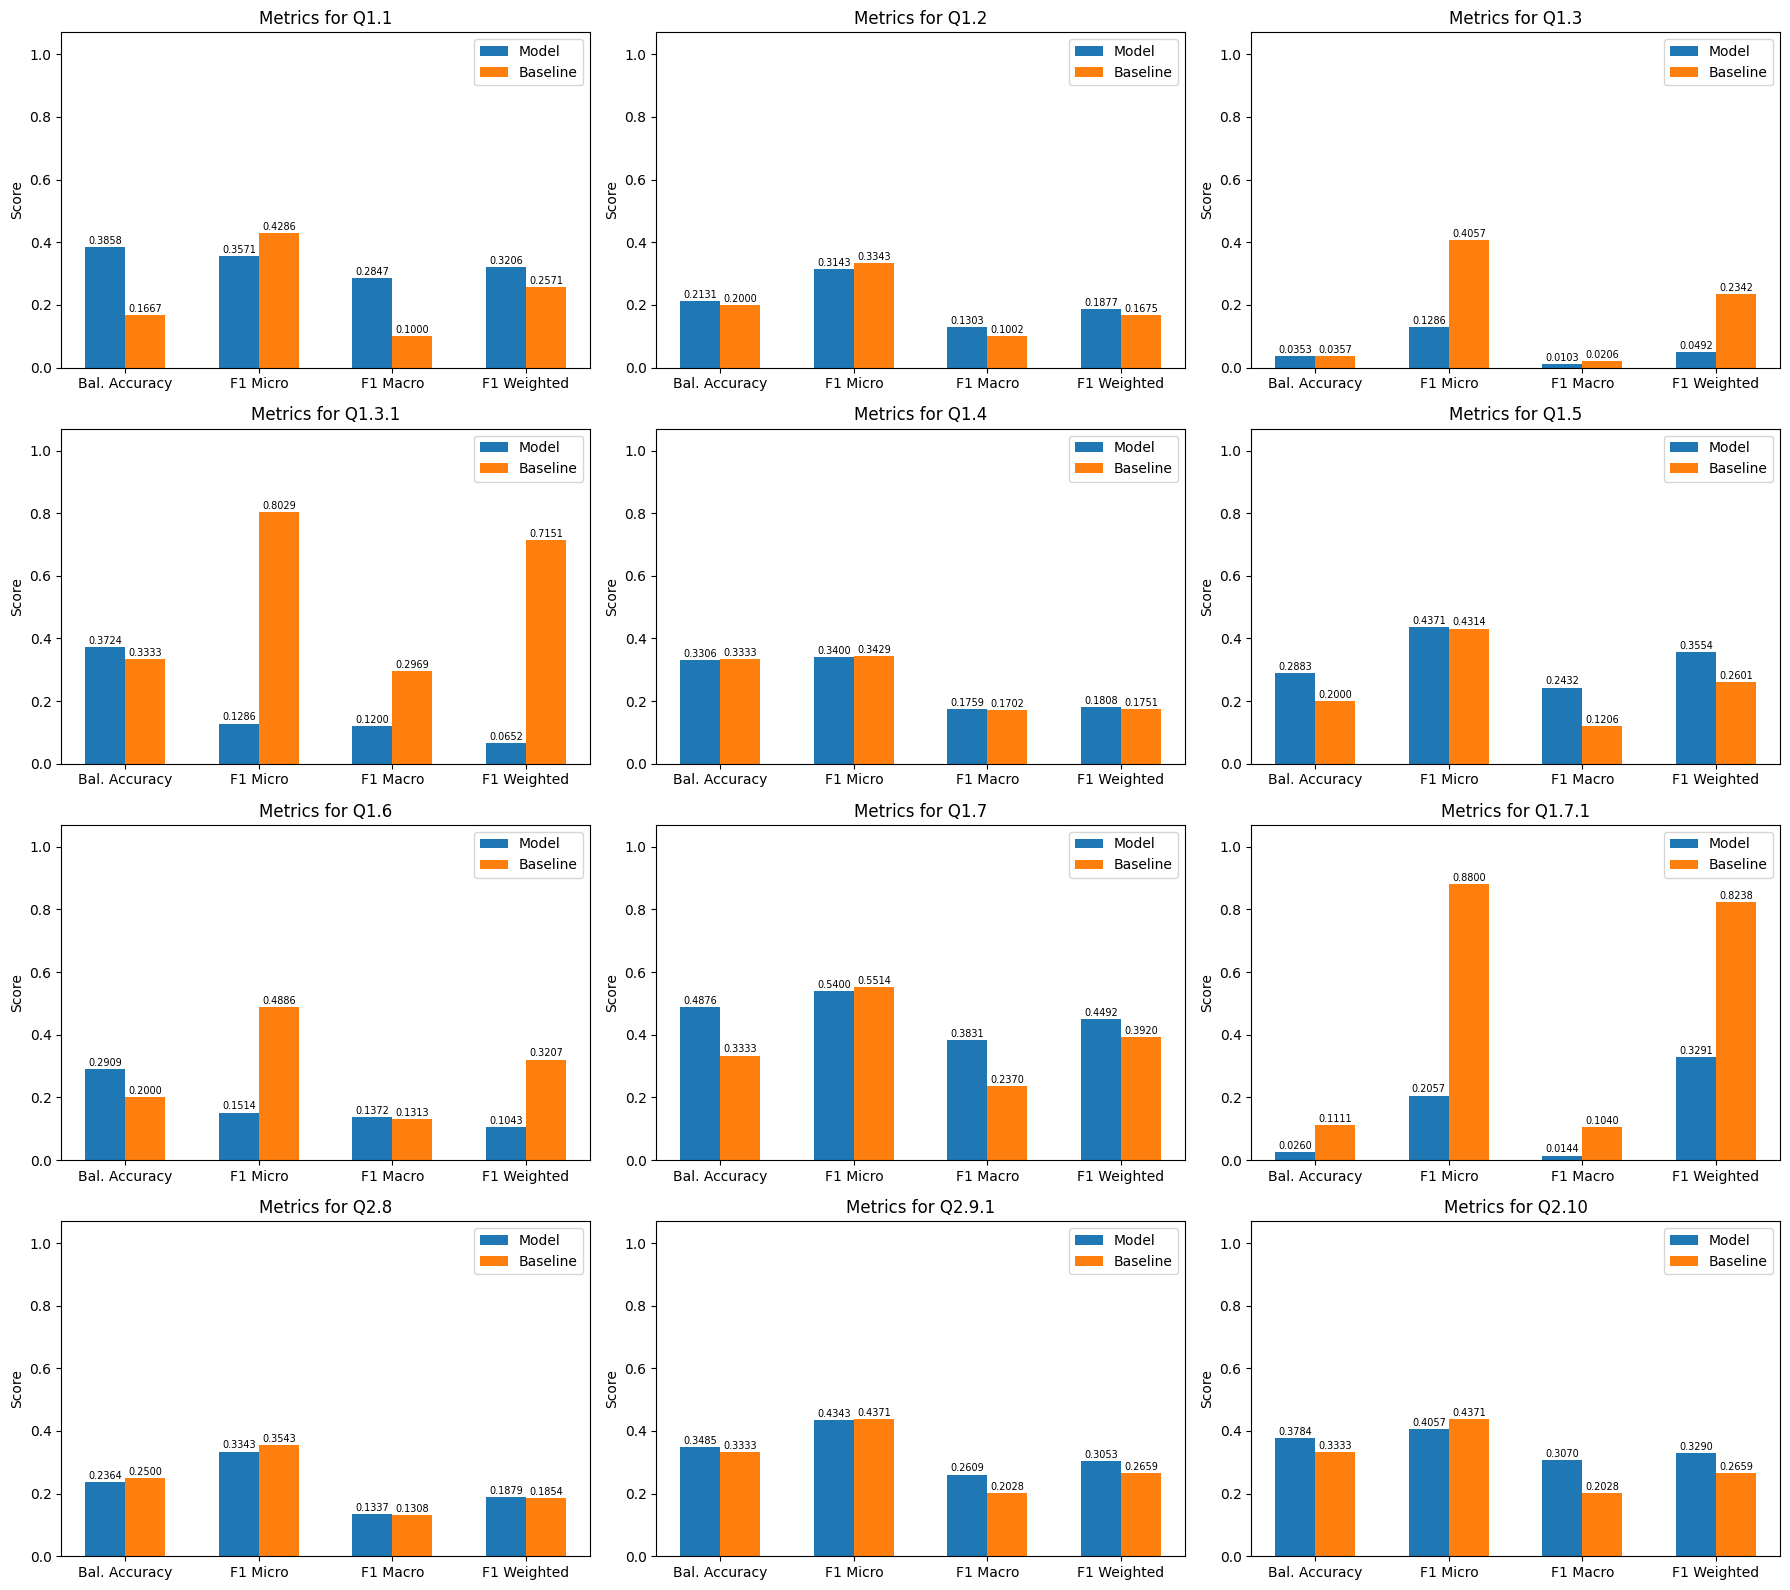

In [17]:
calculate_metrics_per_column('Manuel', 'ChatGPT4AsAnnotator', df)

# Metriche classiche ma con le domande per grado semplificate (2 classi anziché 4) per le domande 1.2, 1.6 e 1.5

In [18]:
def semplify_column(column):
  """
  Trasforma una colonna in base alle condizioni specificate.

  Args:
    column: La colonna da trasformare (serie Pandas).

  Returns:
    La colonna trasformata (serie Pandas).
  """
  
  column = column.copy()
  column[column < 3] = 1
  column[column > 2] = 2
  return column


semplified_df = df

semplified_df["Q1.2"] = semplify_column(semplified_df["Q1.2"])
semplified_df["Q1.5"] = semplify_column(semplified_df["Q1.5"])
semplified_df["Q1.6"] = semplify_column(semplified_df["Q1.6"])


In [19]:
semplified_df

,id,title,label,annotator,Q1.1,Q1.2,Q1.3,Q1.3.1,Q1.4,Q1.5,Q1.6,Q1.7,Q1.7.1,Q2.8,Q2.9.1,Q2.10
0,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Manuel,1,1,31,-1,2,2,2,1,0,1,2,2
1,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Marinella,-1,1,0,-1,-1,1,1,-1,0,-1,-1,-1
2,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Angelo,1,2,10,1,1,2,2,1,0,1,2,2
3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Group 2,Manuel,1,2,10,-1,2,2,2,1,0,3,2,2
4,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Group 2,Marinella,1,2,10,-1,1,2,2,2,5,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,95357073-ff48-47ab-a0ad-62324150033a,L’imprenditore che produce monoclonali a Latin...,Group 1,ChatGPT4AsAnnotator,3,2,1,2,2,2,2,1,1,3,2,2
1409,d30b11b6-a665-438c-8ee2-12ea175daeb5,"I nuovi colori da lunedì 17 maggio, l’ordinanz...",Group 1,ChatGPT4AsAnnotator,1,2,1,2,2,2,2,1,0,3,2,2
1410,abe99528-6405-4ebb-9b2f-2e76fb08ac53,Anche le Carresi inseguono la Zona Bianca,Group 2,ChatGPT4AsAnnotator,3,2,1,2,2,2,2,1,1,3,2,1
1411,8633735e-f183-4d8e-a1e7-9d49b1a2a7b4,Le stoccate di Draghi per infilzare Conte,Group 1,ChatGPT4AsAnnotator,2,2,1,2,2,1,1,2,11,3,2,1


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


<Figure size 640x480 with 0 Axes>

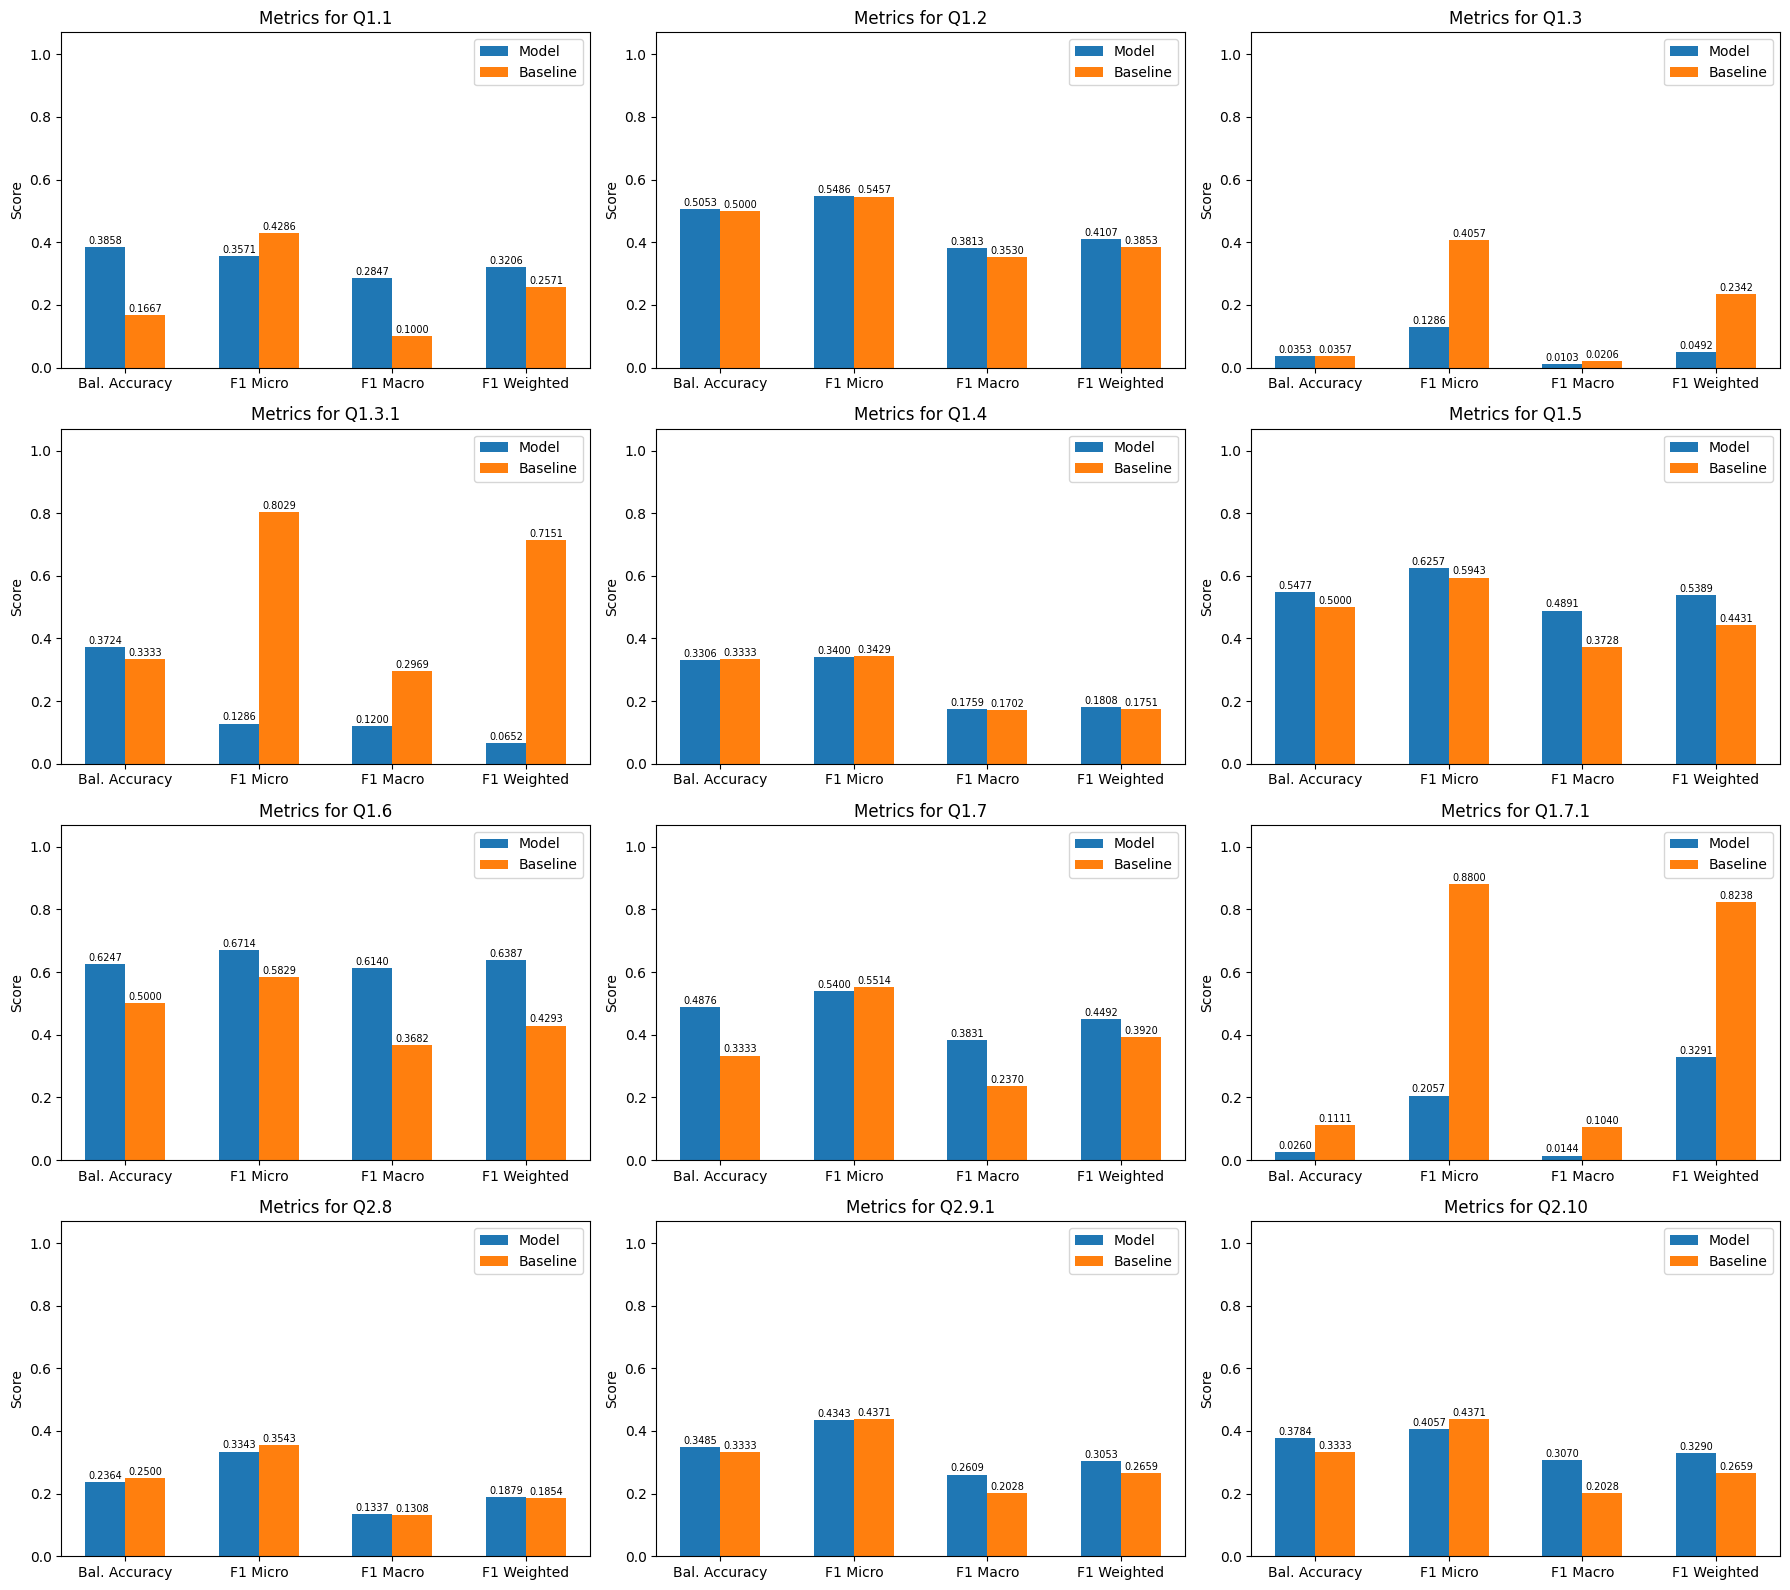

In [20]:
calculate_metrics_per_column('Manuel', 'ChatGPT4AsAnnotator', semplified_df)


 
 # Matrici di confusione solo per i valori inseriti

Manuel VS ChatGPT4AsAnnotator


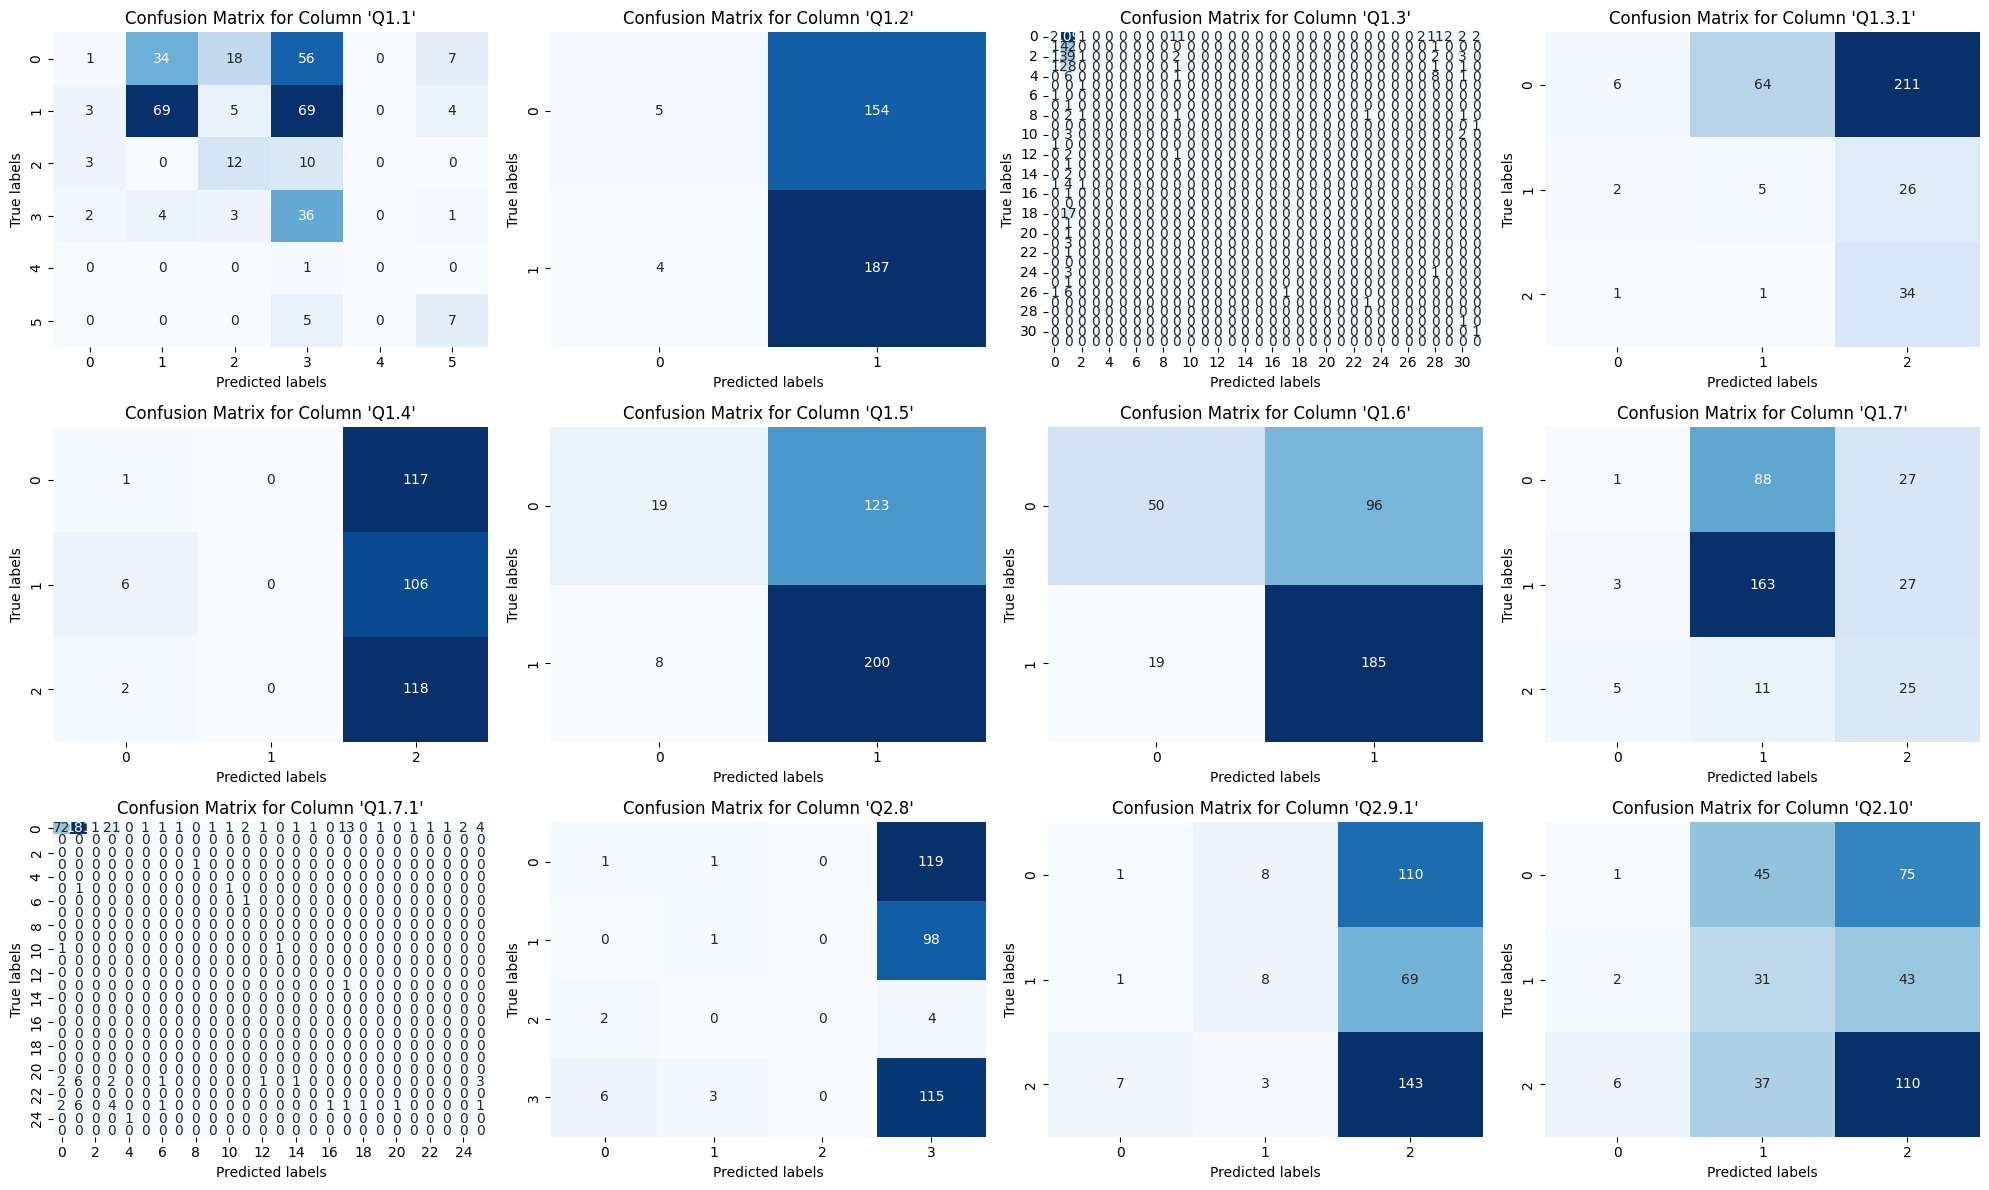

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(annotator_1, annotator_2, columns):
    confusion_matrices = {}
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred)
    plot_confusion_matrices(confusion_matrices)
    return 0

def plot_confusion_matrices(conf_matrices):
    num_cols = len(conf_matrices)
    num_rows = int(np.ceil(num_cols / 4))  # Calcola il numero di righe necessarie per mostrare 4 matrici per riga
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        row = i // 4  # Calcola la riga corrente
        col = i % 4   # Calcola la colonna corrente
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[row, col])
        axes[row, col].set_xlabel("Predicted labels")
        axes[row, col].set_ylabel("True labels")
        axes[row, col].set_title(f"Confusion Matrix for Column '{column}'")

    plt.tight_layout()
    plt.show()

columns_to_consider = ["Q1.1", "Q1.2", "Q1.3", "Q1.3.1", "Q1.4", "Q1.5", "Q1.6", "Q1.7", "Q1.7.1", "Q2.8", "Q2.9.1", "Q2.10"]
print('Manuel VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider)


# Matrici di confusione considerando tutti i valori possibili per ogni risposta

Manuel VS ChatGPT4AsAnnotator


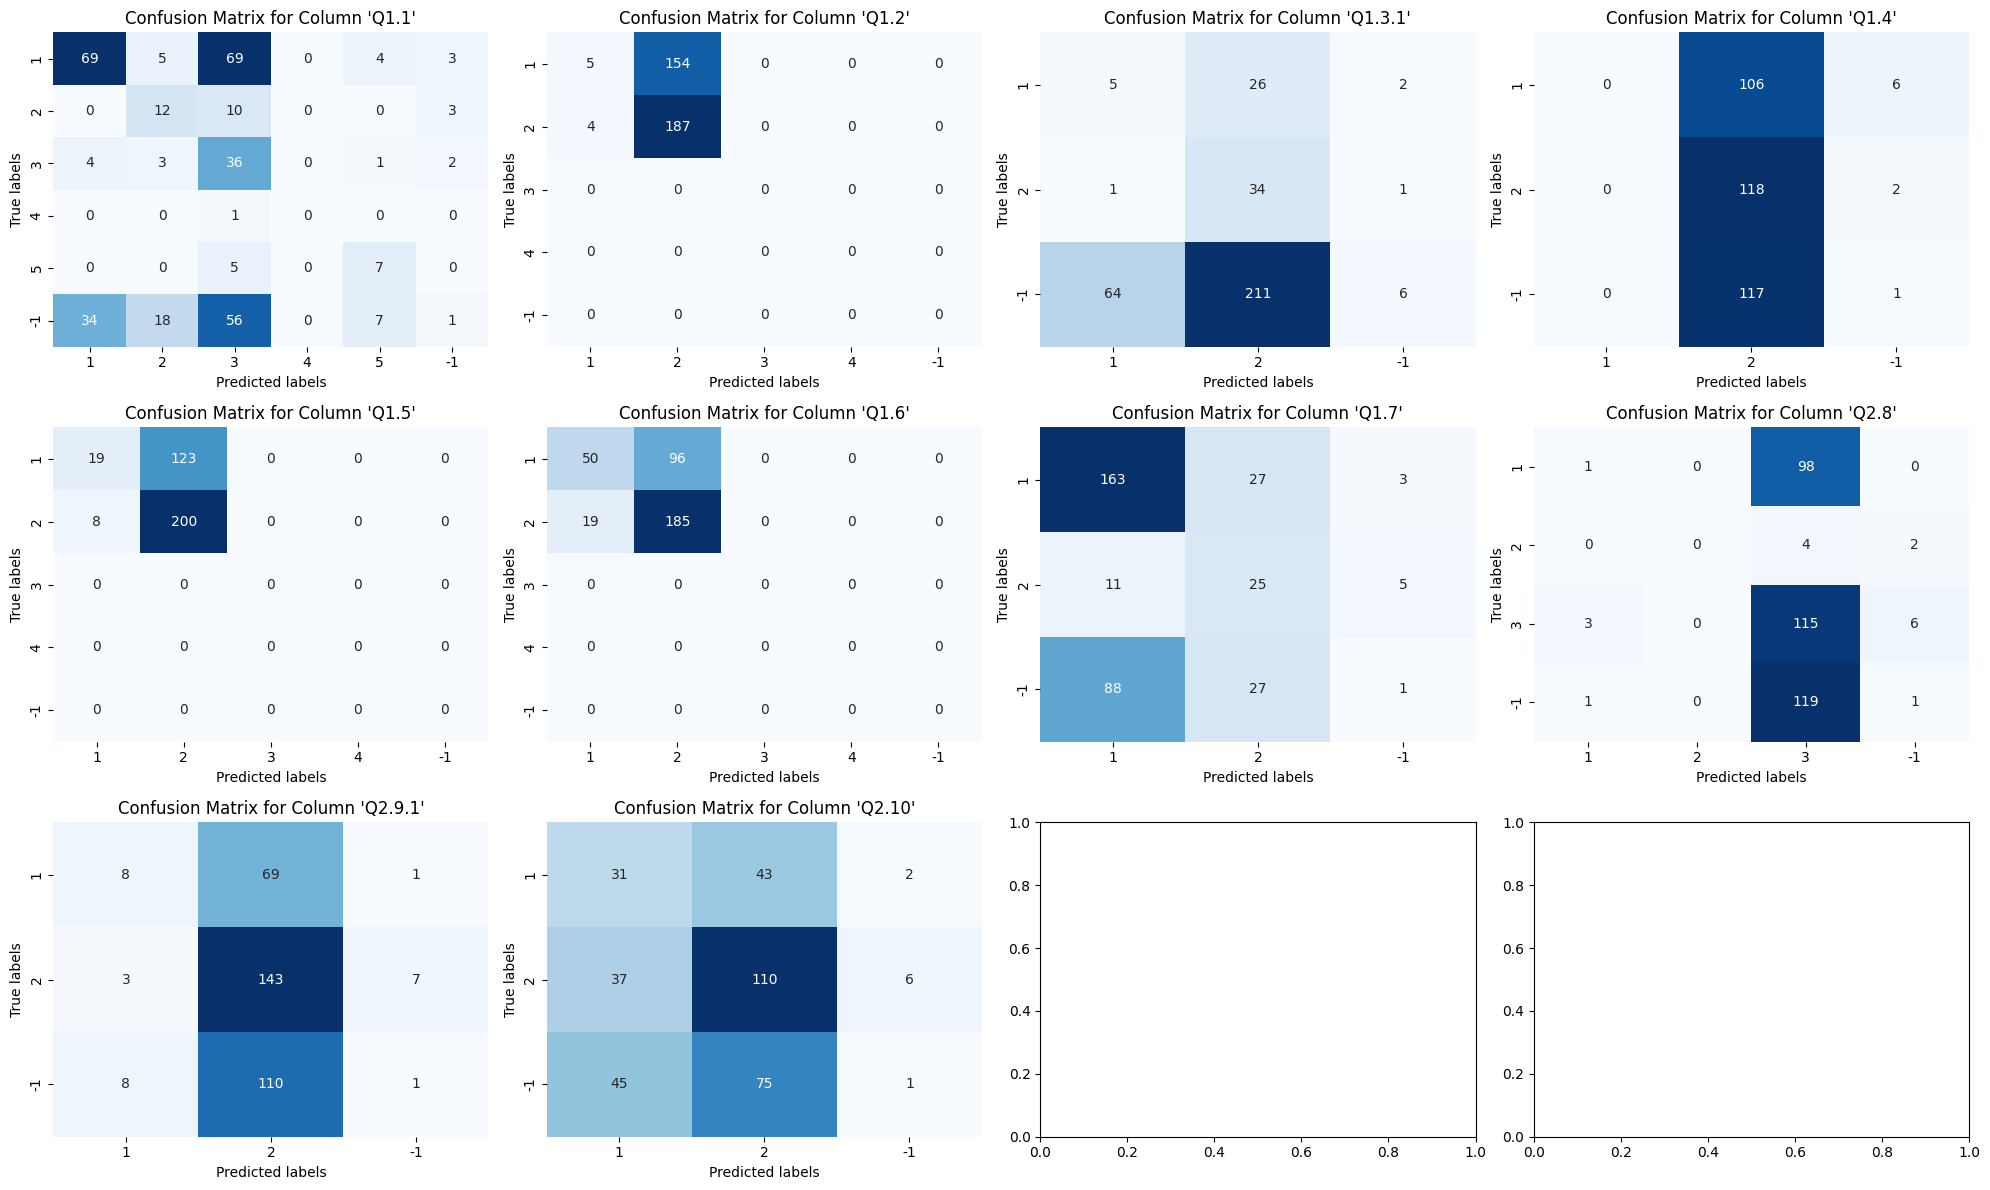

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(annotator_1, annotator_2, columns, possible_values):
    confusion_matrices = {}
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred, labels=possible_values[column])
    plot_confusion_matrices(confusion_matrices, possible_values)
    return 0

def plot_confusion_matrices(conf_matrices, possible_values):
    num_cols = len(conf_matrices)
    num_rows = int(np.ceil(num_cols / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        row = i // 4
        col = i % 4
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[row, col], 
                    xticklabels=possible_values[column], yticklabels=possible_values[column])
        axes[row, col].set_xlabel("Predicted labels")
        axes[row, col].set_ylabel("True labels")
        axes[row, col].set_title(f"Confusion Matrix for Column '{column}'")

    plt.tight_layout()
    plt.show()

columns_to_consider = ["Q1.1", "Q1.2", "Q1.3.1", "Q1.4", "Q1.5", "Q1.6", "Q1.7", "Q2.8", "Q2.9.1", "Q2.10"]
possible_values = {
    'Q1.1': ['1', '2', '3', '4', '5', '-1'], 
    'Q1.2': ['1', '2', '3', '4', '-1'],
    'Q1.3.1': ['1', '2', '-1'],
    'Q1.4': ['1', '2', '-1'],
    'Q1.5': ['1', '2', '3', '4', '-1'],
    'Q1.6': ['1', '2', '3', '4', '-1'],
    'Q1.7': ['1', '2', '-1'],
    'Q2.8': ['1', '2', '3', '-1'],
    'Q2.9.1': ['1', '2', '-1'],
    'Q2.10': ['1', '2', '-1']
}

print('Manuel VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)
